In [11]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [24]:
labelPath = 'data/labels.txt'
dataPath = 'data'

In [25]:
with open(labelPath, 'r') as f:
    lines = f.readlines()
    actions = [line.strip().split()[0] for line in lines]
    labels = [line.strip().split()[1] for line in lines]
    
data = np.concatenate([
    np.load(f'{dataPath}/seq_{action.strip()}.npy') for action in actions
], axis=0)

In [26]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

x_data.shape, labels.shape
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))

y_data.shape
y_data

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [28]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2022)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(793, 30, 99) (793, 3)
(89, 30, 99) (89, 3)


In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                41984     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [52]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# early_stopping = EarlyStopping(
#     monitor='val_loss',  # 모니터링할 지표
#     min_delta=0.000005,  # 개선이 없다고 판단하기 위한 최소 변화량
#     patience=30,  # 지정된 epochs 만큼 개선이 없으면 학습을 조기 종료
#     verbose=1,  # 조기 종료가 되었을 때 출력 여부
#     mode='auto',  # 모니터링할 지표 방향
#     baseline=None,  # 모니터링 지표 기준이 될 값
#     restore_best_weights=True  # 조기 종료되기 전 가장 좋은 가중치 저장 여부
# )

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1, mode='auto'),
        # early_stopping
    ]
)

Epoch 1/200
22/25 [=========================>....] - ETA: 0s - loss: 0.0193 - acc: 0.9943
Epoch 1: val_acc improved from -inf to 0.98876, saving model to models\model.h5
25/25 [==============================] - 0s 11ms/step - loss: 0.0175 - acc: 0.9950 - val_loss: 0.0800 - val_acc: 0.9888 - lr: 1.2500e-04
Epoch 2/200
24/25 [===========================>..] - ETA: 0s - loss: 0.0164 - acc: 0.9948
Epoch 2: val_acc did not improve from 0.98876
25/25 [==============================] - 0s 8ms/step - loss: 0.0163 - acc: 0.9950 - val_loss: 0.0630 - val_acc: 0.9888 - lr: 1.2500e-04
Epoch 3/200
22/25 [=========================>....] - ETA: 0s - loss: 0.0093 - acc: 0.9986
Epoch 3: val_acc did not improve from 0.98876
25/25 [==============================] - 0s 8ms/step - loss: 0.0112 - acc: 0.9975 - val_loss: 0.0545 - val_acc: 0.9888 - lr: 1.2500e-04
Epoch 4/200
24/25 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 0.9948
Epoch 4: val_acc did not improve from 0.98876
25/25 [======

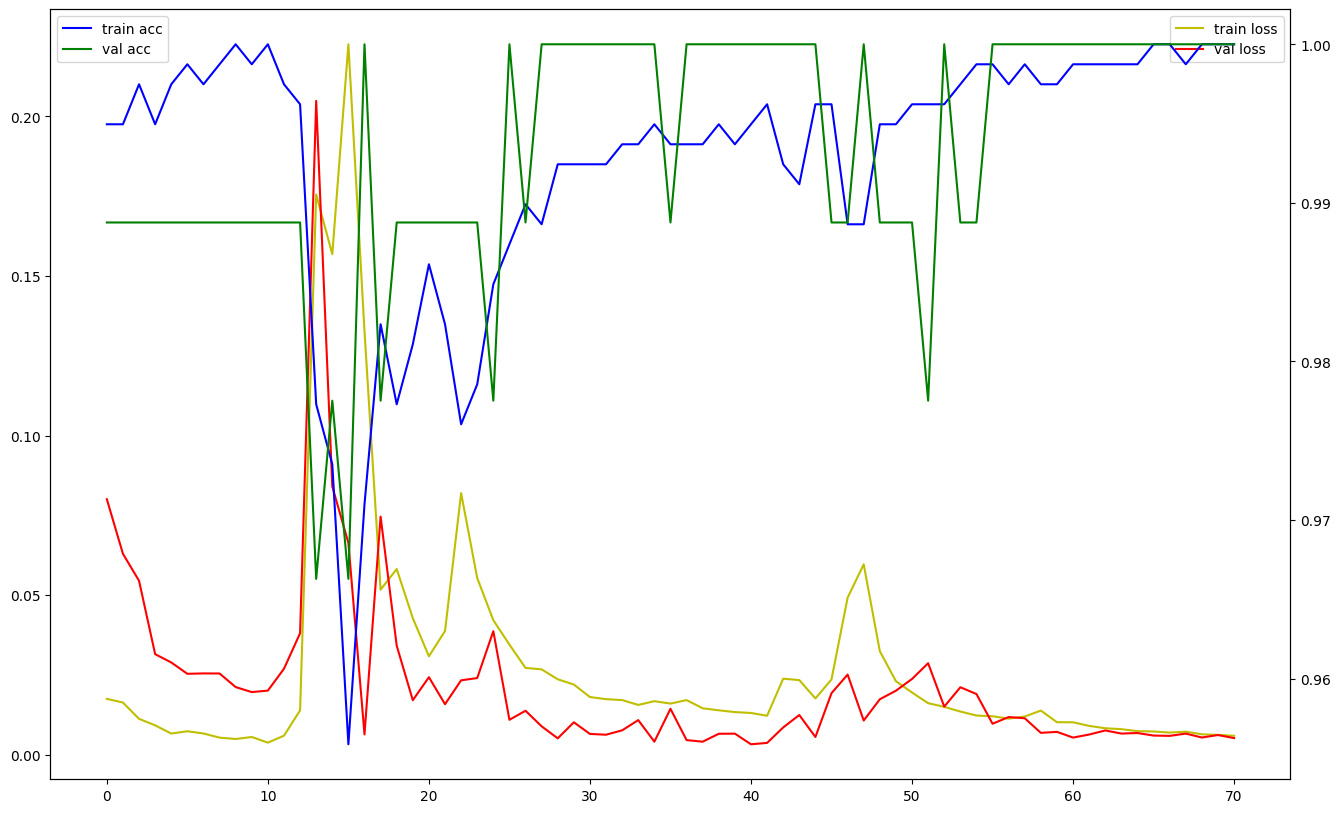

In [53]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.legend(loc='upper right')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.legend(loc='upper left')

plt.show()